In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, average_precision_score, precision_recall_curve
from scipy import interp
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import joblib
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
import plotly.express as px
from sklearn.decomposition import PCA
import umap
import matplotlib
import operator

/Users/giulia/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/giulia/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/giulia/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.2

In [2]:
# Set 
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['font.size'] = 10

# Key Functions

In [10]:
#AUC ROC Curve Scoring Function for Multi-class Classification
def multiclass_roc_auc_score(y_test, y_probs, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    return roc_auc_score(y_test, y_probs, average=average)

def multiclass_average_precision_score(y_test, y_probs, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    return average_precision_score(y_test, y_probs, average=average)

def multiclass_roc_curve(y_test, y_probs):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    fpr = dict()
    tpr = dict()
    for i in range(y_probs.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_probs[:, i])
        
    return (fpr, tpr)

def multiclass_average_precision_curve(y_test, y_probs):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    precision = dict()
    recall = dict()
    for i in range(y_probs.shape[1]):
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_probs[:, i])
    
    return (precision, recall)

def Precisionkfold(X,y,splits,smoteflag):
    numfolds=5;
    numlabels=4;
    Xs = np.copy(X)
    ys=np.copy(y)
    
    if smoteflag==True:
        smote=SMOTE()
        Xs, ys= smote.fit_sample(Xs, ys)

    performancesAccuracy=np.empty([numfolds, 1]);
    
    
    index=0
    for train, test in splits:
        clf = RandomForestClassifier(n_estimators = 200, max_features='sqrt', max_depth=420,random_state=0)
        clf.fit(Xs[train,:], ys[train])

        # Predicting the Test set results
        y_pred = clf.predict(Xs[test,:])
        performancesAccuracy[index]=accuracy_score(ys[test], y_pred)
        index+=1

    return performancesAccuracy
    
    
# returns performances and splits/models used in the cross-validation
def AUCAUPkfold(X,y,smoteflag,verbose=True):
    numfolds=5;
    numlabels=4;
    cv = StratifiedKFold(n_splits=numfolds, shuffle=True)
    Xs = np.copy(X)
    ys=np.copy(y)
    
    if smoteflag==True:
        smote=SMOTE()
        Xs, ys= smote.fit_sample(Xs, ys)
        
    performancesAUC=np.empty([numfolds, numlabels]);
    performancesAUP=np.empty([numfolds, numlabels]);
    splits=[];
    model_per_fold=[]
    index=0
    for train, test in cv.split(Xs, ys):
        clf = RandomForestClassifier(n_estimators = 200, max_features='sqrt', max_depth=420, random_state=0)
        
        splits.append([train, test])
        clf.fit(Xs[train,:], ys[train])

        # Predicting the Test set results
        y_pred = clf.predict(Xs[test,:])
        y_probs= clf.predict_proba(Xs[test,:])
        performancesAUC[index,:]=np.array(multiclass_roc_auc_score(ys[test], y_probs, average=None))
        performancesAUP[index,:]=np.array(multiclass_average_precision_score(ys[test], y_probs, average=None))
        index+=1
        model_per_fold.append(clf)
    
    if verbose==True:
        print("AUC: average over the folds")
        print(performancesAUC.mean(axis=0))
        print("AUC: std over the folds")
        print(performancesAUC.std(axis=0))
        
    if verbose==True:
        print("AUP: average over the folds")
        print(performancesAUP.mean(axis=0))
        print("AUP: std over the folds")
        print(performancesAUP.std(axis=0))
        
        
    return (performancesAUC, performancesAUP, splits, model_per_fold) 


def ROCkfold(X,y,splits,smoteflag,verbose=True):
    numfolds=5;
    numlabels=4;
    Xs = np.copy(X)
    ys=np.copy(y)
    
    if smoteflag==True:
        smote=SMOTE()
        Xs, ys= smote.fit_sample(Xs, ys)
        
    
    mean_fpr = np.linspace(0, 1, 500)
    performancesAUC=np.empty([numfolds, numlabels]);
    performancesROC=[np.empty([numfolds,len(mean_fpr)]) for ind in range(numlabels)];
    
    
    index=0
    for train, test in splits:
        clf = RandomForestClassifier(n_estimators = 200, max_features='sqrt', max_depth=420,random_state=0)
        clf.fit(Xs[train,:], ys[train])

        # Predicting the Test set results
        y_pred = clf.predict(Xs[test,:])
        y_probs= clf.predict_proba(Xs[test,:])
        # ROC curve for the classes--> returns two dictionaries
        fprclasses, tprclasses=multiclass_roc_curve(ys[test], y_probs)
        
        for c in range(numlabels):
            interp_tpr = interp(mean_fpr, fprclasses[c], tprclasses[c])
            interp_tpr[0] = 0.0
            performancesROC[c][index, :]=interp_tpr
            
        
        performancesAUC[index,:]=np.array(multiclass_roc_auc_score(ys[test], y_probs, average=None))
        index+=1
            
            
    mean_tpr =[np.empty([1,len(mean_fpr)]) for ind in range(numlabels)];
    std_tpr =[np.empty([1,len(mean_fpr)]) for ind in range(numlabels)];
    tprs_upper =[np.empty([1,len(mean_fpr)]) for ind in range(numlabels)];
    tprs_lower =[np.empty([1,len(mean_fpr)]) for ind in range(numlabels)];
    
    for c in range(numlabels):
        mean_tpr[c]=np.mean(performancesROC[c], axis=0)
        mean_tpr[c][-1] = 1.0
        std_tpr[c]=np.std(performancesROC[c], axis=0)
        tprs_upper[c]=np.minimum(mean_tpr[c] + std_tpr[c], 1)
        tprs_lower[c]=np.maximum(mean_tpr[c] - std_tpr[c], 0)   
    
    if verbose==True:
        print("AUC: average over the folds")
        print(performancesAUC.mean(axis=0))
        print("AUC: std over the folds")
        print(performancesAUC.std(axis=0))
        
    return performancesAUC, performancesROC, mean_fpr, mean_tpr, std_tpr, tprs_upper, tprs_lower

def ROCplot(mean_fpr, mean_tpr, std_tpr, tprs_upper, tprs_lower, performancesAUC, labelc):
    mean_auc=performancesAUC.mean(axis=0)
    std_auc=performancesAUC.std(axis=0)
                                
    fig, ax = plt.subplots()
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    ax.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="ROC "+"Class "+ str(labelc+1))
    ax.legend(loc="lower right")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    
def ROCMultiPlot(mean_fprL, mean_tprL, std_tprL, tprs_upperL, tprs_lowerL, performancesAUCL, labelc, labeld, colord):
    mean_auc=[p.mean(axis=0) for p in  performancesAUCL]
    std_auc=[p.std(axis=0) for p in  performancesAUCL]

    fig, ax = plt.subplots(figsize=(5, 5))
    #ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    
    for d in range(len(labeld)):
        ax.plot(mean_fprL[d], mean_tprL[d], color=colord[d],label=labeld[d]+ r': AUC = %0.4f $\pm$ %0.4f' % (mean_auc[d], std_auc[d]), lw=2, alpha=.5)
        ax.fill_between(mean_fprL[d], tprs_lowerL[d], tprs_upperL[d], color=colord[d], alpha=.1)



    ax.set(xlim=[0, 1], ylim=[0, 1], title="ROC "+"Class "+ str(labelc+1))        
    ax.legend(loc="lower right")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    
def PrecisionRecallCurvekfold(X,y,splits,smoteflag,verbose=True):
    numfolds=5;
    numlabels=4;
    Xs = np.copy(X)
    ys=np.copy(y)
    
    if smoteflag==True:
        smote=SMOTE()
        Xs, ys= smote.fit_sample(Xs, ys)
        
    
    mean_recall = np.linspace(1, 0, 500)
    performancesAUP=np.empty([numfolds, numlabels]);
    performancesPrecisionRecall=[np.empty([numfolds,len(mean_recall)]) for ind in range(numlabels)];
    
    
    index=0
    for train, test in splits:
        clf = RandomForestClassifier(n_estimators = 200, max_features='sqrt', max_depth=420,random_state=0)
        clf.fit(Xs[train,:], ys[train])

        # Predicting the Test set results
        y_pred = clf.predict(Xs[test,:])
        y_probs= clf.predict_proba(Xs[test,:])
        # Precision-Recall curve for the classes--> returns two dictionaries
        precisionclasses, recallclasses=multiclass_average_precision_curve(ys[test], y_probs)
       
        
        for c in range(numlabels):
            interp_precision = interp(mean_recall, recallclasses[c][::-1], precisionclasses[c][::-1])
            performancesPrecisionRecall[c][index, :]=interp_precision
            
        
        performancesAUP[index,:]=np.array(multiclass_average_precision_score(ys[test], y_probs, average=None))
        index+=1
            
            
    mean_precision =[np.empty([1,len(mean_recall)]) for ind in range(numlabels)];
    std_precision =[np.empty([1,len(mean_recall)]) for ind in range(numlabels)];
    precision_upper =[np.empty([1,len(mean_recall)]) for ind in range(numlabels)];
    precision_lower =[np.empty([1,len(mean_recall)]) for ind in range(numlabels)];
    
    for c in range(numlabels):
        mean_precision[c]=np.mean(performancesPrecisionRecall[c], axis=0)
        std_precision[c]=np.std(performancesPrecisionRecall[c], axis=0)
        precision_upper[c]=np.minimum(mean_precision[c] + std_precision[c], 1)
        precision_lower[c]=np.maximum(mean_precision[c] - std_precision[c], 0)   
    
    if verbose==True:
        print("AUP: average over the folds")
        print(performancesAUP.mean(axis=0))
        print("AUP: std over the folds")
        print(performancesAUP.std(axis=0))
        
    return performancesAUP, performancesPrecisionRecall, mean_recall, mean_precision, std_precision, precision_upper, precision_lower

def PrecisionRecallplot(mean_recall, mean_precision, std_precision, precision_upper, precision_lower, performancesAUP, labelc):
    mean_aup=performancesAUP.mean(axis=0)
    std_aup=performancesAUP.std(axis=0)
                                
    fig, ax = plt.subplots()
    ax.plot(mean_recall, mean_precision, color='b',label=r'Mean Precision Recall (AUP = %0.2f $\pm$ %0.2f)' % (mean_aup, std_aup), lw=2, alpha=.8)
    ax.fill_between(mean_recall, precision_lower, precision_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Precision-Recall Curve "+ "Class "+ str(labelc +1))
    ax.legend(loc="lower left")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

def PrecisionRecallMultiPlot(mean_recallL, mean_precisionL, std_precisionL, precision_upperL, precision_lowerL, performancesAUPL, labelc, labeld, colord):
    mean_aup=[p.mean(axis=0) for p in  performancesAUPL]
    std_aup=[p.std(axis=0) for p in  performancesAUPL]
    
    fig, ax = plt.subplots(figsize=(5, 5))
    
    for d in range(len(labeld)):
        ax.plot(mean_recallL[d], mean_precisionL[d], color=colord[d],label=labeld[d]+ r': AUP = %0.4f $\pm$ %0.4f' % (mean_aup[d], std_aup[d]), lw=2, alpha=.5)
        ax.fill_between(mean_recallL[d], precision_lowerL[d], precision_upperL[d], color=colord[d], alpha=.1)



    ax.set(xlim=[0, 1], ylim=[0, 1], title="Precision-Recall Curve "+ "Class "+ str(labelc +1)) 
    ax.legend(loc="lower left")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

# Load Training Data

In [3]:
RFFNDDS=pd.read_csv('FNDDS_2009-10_Training_Data.csv')
RFFNDDS

,Protein,Total Fat,Carbohydrate,Alcohol,Water,Caffeine,Theobromine,"Sugars, total","Fiber, total dietary",Calcium,...,Total flavones,Total flavonols,Total isoflavones,Food_code,Main_food_description,catnumb,catname,novaclass,macroclass,pythonlabel
0,-20.000000,-20.000000,-20.000000,-20.0,-1.609438,-20.0,-20.0,-20.000000,-20.0,-3.729701,...,-20.0,-20.0,-20.0,2047,"Salt, table",0,addition1516,2,Other,1
1,0.029559,1.477049,1.930071,-20.0,4.471639,-20.0,-20.0,1.930071,-20.0,-3.442019,...,-20.0,-20.0,-20.0,11000000,"Milk, human",9602,Human milk,1,Milk,0
2,1.187843,0.647103,1.578979,-20.0,4.491441,-20.0,-20.0,1.625311,-20.0,-2.128632,...,-20.0,-20.0,-20.0,11100000,"Milk, NFS",1004,"Milk, reduced fat",1,Milk,0
3,1.147402,1.178655,1.568616,-20.0,4.478813,-20.0,-20.0,1.619388,-20.0,-2.180367,...,-20.0,-20.0,-20.0,11111000,"Milk, cow's, fluid, whole",1002,"Milk, whole",1,Milk,0
4,1.131402,1.241269,1.495149,-20.0,4.479607,-20.0,-20.0,1.495149,-20.0,-2.292635,...,-20.0,-20.0,-20.0,11111100,"Milk, cow's, fluid, whole, low-sodium",1002,"Milk, whole",1,Milk,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7249,-20.000000,-20.000000,-1.897120,-20.0,4.603669,-20.0,-20.0,-20.000000,-20.0,-6.907755,...,-20.0,-20.0,-20.0,94100200,"Water, bottled, sweetened, with low or no calo...",7802,Flavored or carbonated water,4,Other,3
7250,-20.000000,-20.000000,1.504077,-20.0,4.547965,-20.0,-20.0,1.504077,-20.0,-4.074542,...,-20.0,-20.0,-20.0,94100300,"Water, fruit flavored, sweetened, with high fr...",7802,Flavored or carbonated water,4,Other,3
7251,-20.000000,-20.000000,0.198851,-20.0,4.592895,-20.0,-20.0,0.198851,-20.0,-6.907755,...,-20.0,-20.0,-20.0,94210100,Propel Water,7804,Enhanced or fortified water,4,Other,3
7252,-20.000000,-20.000000,1.702928,-20.0,4.547965,-20.0,-20.0,1.702928,-20.0,-4.074542,...,-20.0,-20.0,-20.0,94210200,Glaceau Water,7804,Enhanced or fortified water,4,Other,3


In [4]:
# total nutrient list
nl=list(RFFNDDS.columns)
nl=nl[0:-7]
len(nl)

99

In [15]:
# Nutrition Facts
nutrition_facts=['Protein','Total Fat','Carbohydrate','Sugars, total','Fiber, total dietary','Calcium','Iron', 'Sodium','Retinol','Carotene, beta',
 'Carotene, alpha','Cryptoxanthin, beta','Vitamin C','Cholesterol', 'Fatty acids, total saturated'];
VitaminA=['Retinol','Carotene, beta','Carotene, alpha','Cryptoxanthin, beta']

RFFNDDSNF=RFFNDDS[nutrition_facts]
RFFNDDSNF['Total Vitamin A']=RFFNDDS[VitaminA].apply(np.exp).sum(axis=1).apply(np.log)
RFFNDDSNF=RFFNDDSNF.drop(VitaminA, axis=1)

print(len(RFFNDDSNF.columns))
print(RFFNDDSNF.columns)
RFFNDDSNF

12
Index(['Protein', 'Total Fat', 'Carbohydrate', 'Sugars, total',
       'Fiber, total dietary', 'Calcium', 'Iron', 'Sodium', 'Vitamin C',
       'Cholesterol', 'Fatty acids, total saturated', 'Total Vitamin A'],
      dtype='object')


,Protein,Total Fat,Carbohydrate,"Sugars, total","Fiber, total dietary",Calcium,Iron,Sodium,Vitamin C,Cholesterol,"Fatty acids, total saturated",Total Vitamin A
0,-20.000000,-20.000000,-20.000000,-20.000000,-20.0,-3.729701,-8.016418,3.657337,-20.000000,-20.000000,-20.000000,-18.613706
1,0.029559,1.477049,1.930071,1.930071,-20.0,-3.442019,-10.414313,-4.074542,-5.298317,-4.268698,0.697637,-9.610756
2,1.187843,0.647103,1.578979,1.625311,-20.0,-2.128632,-10.414313,-3.123566,-9.210340,-4.961845,0.143234,-9.772387
3,1.147402,1.178655,1.568616,1.619388,-20.0,-2.180367,-10.414313,-3.146555,-20.000000,-4.605170,0.623261,-9.864188
4,1.131402,1.241269,1.495149,1.495149,-20.0,-2.292635,-9.903488,-5.809143,-7.013116,-4.268698,0.767327,-10.260045
...,...,...,...,...,...,...,...,...,...,...,...,...
7249,-20.000000,-20.000000,-1.897120,-20.000000,-20.0,-6.907755,-20.000000,-5.809143,-20.000000,-20.000000,-20.000000,-18.613706
7250,-20.000000,-20.000000,1.504077,1.504077,-20.0,-4.074542,-20.000000,-4.828314,-4.366153,-20.000000,-20.000000,-10.349581
7251,-20.000000,-20.000000,0.198851,0.198851,-20.0,-6.907755,-10.414313,-4.342806,-4.733004,-20.000000,-20.000000,-18.613706
7252,-20.000000,-20.000000,1.702928,1.702928,-20.0,-4.074542,-20.000000,-20.000000,-4.366153,-20.000000,-20.000000,-10.349581


# Whole Nutrient Panel analysis

In [16]:
# Whole Nutrient Panel
#data to train  and cross validate
data2train=RFFNDDS[RFFNDDS.pythonlabel!=-1]
X=data2train.loc[:, 'Protein': 'Total isoflavones']
y=data2train['pythonlabel']
print(X.shape)

(2971, 99)


In [81]:
smoteflag=False
(performancesAUCWNP, performancesAUPWNP, splitsWNP, model_per_foldWNP)=AUCAUPkfold(X,y,smoteflag);
# to create ROC curves
(performancesAUCWNP, performancesROCWNP, mean_fprWNP, mean_tprWNP, std_tprWNP, tprs_upperWNP, tprs_lowerWNP)=ROCkfold(X,y,splitsWNP,smoteflag)
# to create Precision-Recall curves
(performancesAUPWNP, performancesPrecisionRecallWNP, mean_recallWNP, mean_precisionWNP, std_precisionWNP, precision_upperWNP, precision_lowerWNP)=PrecisionRecallCurvekfold(X,y,splitsWNP,smoteflag)

AUC: average over the folds
[0.97880641 0.96040647 0.97115636 0.98008549]
AUC: std over the folds
[0.00277178 0.05215055 0.00739384 0.00423704]
AUP: average over the folds
[0.88141938 0.74706967 0.87912288 0.9917835 ]
AUP: std over the folds
[0.02409241 0.19338717 0.03260075 0.00195395]


/Users/giulia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/Users/giulia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/Users/giulia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/Users/giulia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/Users/giulia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



AUC: average over the folds
[0.97880641 0.96040647 0.97115636 0.98008549]
AUC: std over the folds
[0.00277178 0.05215055 0.00739384 0.00423704]


/Users/giulia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/Users/giulia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/Users/giulia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/Users/giulia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



AUP: average over the folds
[0.88141938 0.74706967 0.87912288 0.9917835 ]
AUP: std over the folds
[0.02409241 0.19338717 0.03260075 0.00195395]


/Users/giulia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



Use the same cross validation splits for the other resolutions too...use splitsWNP

# standard release FNDDS (for releases without flavonoids)

In [5]:
#labeled as SR
#data to train  and cross validate
data2train=RFFNDDS[RFFNDDS.pythonlabel!=-1]
X=data2train.loc[:, 'Protein': 'Fatty acids, total polyunsaturated']
y=data2train['pythonlabel']
print(X.shape)

(2971, 62)


In [83]:
smoteflag=False
#(performancesAUCSR, performancesAUPSR, splitsSR, model_per_foldSR)=AUCAUPkfold(X,y,smoteflag);
# to create ROC curves
(performancesAUCSR, performancesROCSR, mean_fprSR, mean_tprSR, std_tprSR, tprs_upperSR, tprs_lowerSR)=ROCkfold(X,y,splitsWNP,smoteflag)
# to create Precision-Recall curves
(performancesAUPSR, performancesPrecisionRecallSR, mean_recallSR, mean_precisionSR, std_precisionSR, precision_upperSR, precision_lowerSR)=PrecisionRecallCurvekfold(X,y,splitsWNP,smoteflag)

/Users/giulia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/Users/giulia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/Users/giulia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/Users/giulia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/Users/giulia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



AUC: average over the folds
[0.98083718 0.96287789 0.97060469 0.97986605]
AUC: std over the folds
[0.00172975 0.04858633 0.00806014 0.00487599]


/Users/giulia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/Users/giulia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/Users/giulia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/Users/giulia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



AUP: average over the folds
[0.89197087 0.73624462 0.87302521 0.99170158]
AUP: std over the folds
[0.02441215 0.18574362 0.03922022 0.00217769]


/Users/giulia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



# Nutrition Facts Analysis

In [84]:
# labeled as NF
#data to train  and cross validate
data2train=RFFNDDSNF[RFFNDDS.pythonlabel!=-1]
X=data2train.values
y=RFFNDDS[RFFNDDS.pythonlabel!=-1].pythonlabel
print(X.shape)

(2971, 12)


In [85]:
smoteflag=False
#(performancesAUCNF, performancesAUPNF, splitsNF, model_per_foldNF)=AUCAUPkfold(X,y,smoteflag);
# to create ROC curves
(performancesAUCNF, performancesROCNF, mean_fprNF, mean_tprNF, std_tprNF, tprs_upperNF, tprs_lowerNF)=ROCkfold(X,y,splitsWNP,smoteflag)
# to create Precision-Recall curves
(performancesAUPNF, performancesPrecisionRecallNF, mean_recallNF, mean_precisionNF, std_precisionNF, precision_upperNF, precision_lowerNF)=PrecisionRecallCurvekfold(X,y,splitsWNP,smoteflag)

/Users/giulia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/Users/giulia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/Users/giulia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/Users/giulia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/Users/giulia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



AUC: average over the folds
[0.98166162 0.96634812 0.96709383 0.9767718 ]
AUC: std over the folds
[0.00362133 0.04489795 0.01041119 0.00343188]


/Users/giulia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/Users/giulia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/Users/giulia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/Users/giulia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



AUP: average over the folds
[0.89111232 0.75699718 0.86460485 0.99055763]
AUP: std over the folds
[0.03510461 0.16922495 0.04056587 0.00141449]


/Users/giulia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



# Comparison of Different Nutrient Resolutions

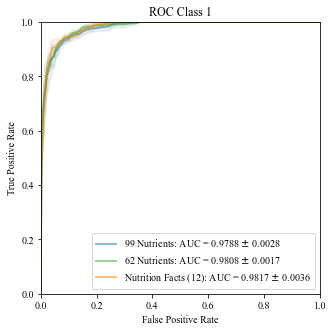

In [86]:
# target 1 specific class
cc=0
mean_fprL=[mean_fprWNP, mean_fprSR, mean_fprNF]
mean_tprL=[mean_tprWNP[cc], mean_tprSR[cc], mean_tprNF[cc]]
std_tprL=[std_tprWNP[cc], std_tprSR[cc], std_tprNF[cc]]
tprs_upperL=[tprs_upperWNP[cc], tprs_upperSR[cc], tprs_upperNF[cc]]
tprs_lowerL=[tprs_lowerWNP[cc], tprs_lowerSR[cc], tprs_lowerNF[cc]]
performancesAUCL=[performancesAUCWNP[:,cc], performancesAUCSR[:,cc], performancesAUCNF[:,cc]]
labeld=['99 Nutrients', '62 Nutrients', 'Nutrition Facts (12)']
colord=[np.array([31,120,180])/255,  np.array([51,160,44])/255, np.array([255,127,0])/255]
ROCMultiPlot(mean_fprL, mean_tprL, std_tprL, tprs_upperL, tprs_lowerL, performancesAUCL, cc, labeld, colord)

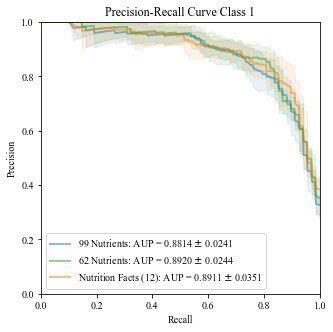

In [87]:
# target 1 specific class
cc=0
mean_recallL=[mean_recallWNP, mean_recallSR, mean_recallNF]
mean_precisionL=[mean_precisionWNP[cc], mean_precisionSR[cc], mean_precisionNF[cc]]
std_precisionL=[std_precisionWNP[cc], std_precisionSR[cc], std_precisionNF[cc]]
precision_upperL=[precision_upperWNP[cc], precision_upperSR[cc], precision_upperNF[cc]]
precision_lowerL=[precision_lowerWNP[cc], precision_lowerSR[cc], precision_lowerNF[cc]]
performancesAUPL=[performancesAUPWNP[:,cc], performancesAUPSR[:,cc], performancesAUPNF[:,cc]]
labeld=['99 Nutrients', '62 Nutrients', 'Nutrition Facts (12)']
colord=[np.array([31,120,180])/255,  np.array([51,160,44])/255, np.array([255,127,0])/255]
PrecisionRecallMultiPlot(mean_recallL, mean_precisionL, std_precisionL, precision_upperL, precision_lowerL, performancesAUPL, cc, labeld, colord)

# Summary Panel

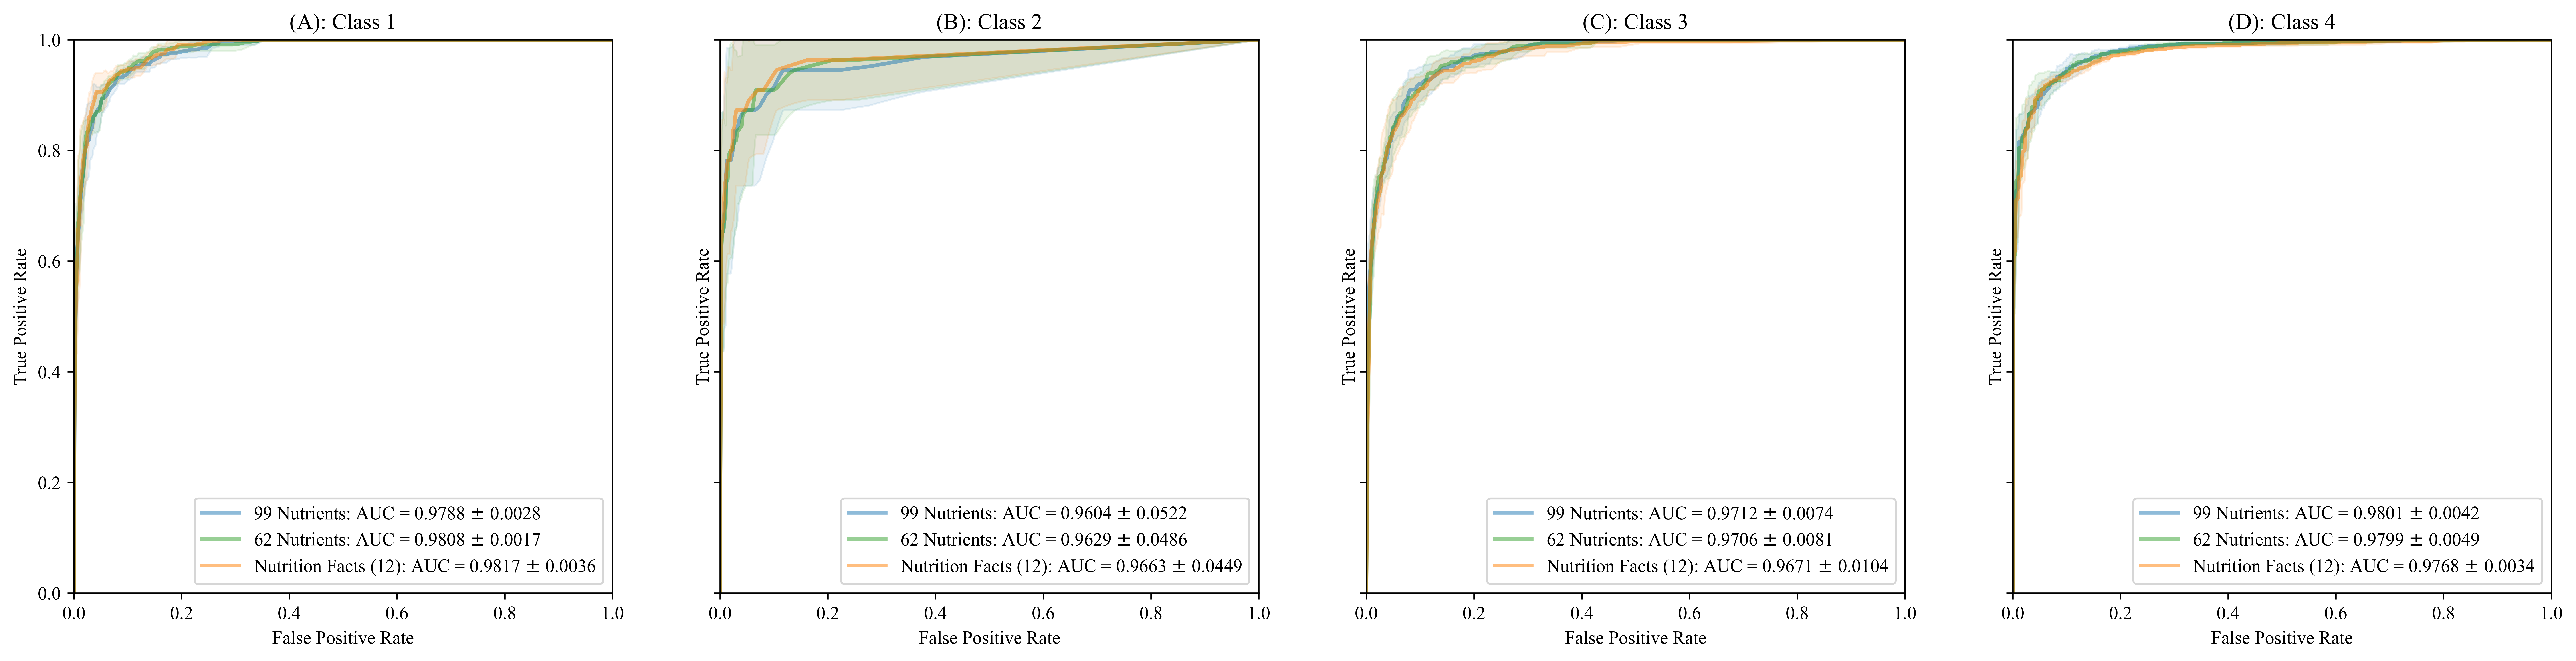

In [106]:
colorclass=[np.array([0.4, 0.7607843137254902, 0.6470588235294118]), np.array([0.9882352941176471, 0.5529411764705883, 0.3843137254901961]),np.array([0.5529411764705883, 0.6274509803921569, 0.796078431372549]), np.array([0.9058823529411765, 0.5411764705882353, 0.7647058823529411])]

def ROCMultiPlotCallable(mean_fprL, mean_tprL, std_tprL, tprs_upperL, tprs_lowerL, performancesAUCL, labelc, labeld, colord,ax):
    mean_auc=[p.mean(axis=0) for p in  performancesAUCL]
    std_auc=[p.std(axis=0) for p in  performancesAUCL]

    
    for d in range(len(labeld)):
        ax.plot(mean_fprL[d], mean_tprL[d], color=colord[d],label=labeld[d]+ r': AUC = %0.4f $\pm$ %0.4f' % (mean_auc[d], std_auc[d]), lw=2, alpha=.5)
        ax.fill_between(mean_fprL[d], tprs_lowerL[d], tprs_upperL[d], color=colord[d], alpha=.1)
      
    ax.legend(loc="lower right")

def LineAUC(performancesAUCL, nuttablenum, labelc, labeld,singlecolor,ax):
    nuttablenum=np.array(nuttablenum)
    mean_auc=np.array([p.mean(axis=0) for p in  performancesAUCL])
    std_auc=np.array([p.std(axis=0) for p in  performancesAUCL])
    ax.plot(np.array(nuttablenum), mean_auc, 'o-', color=singlecolor)
    ax.fill_between(np.array(nuttablenum), mean_auc - std_auc, mean_auc + std_auc, color=singlecolor, alpha=0.1)    
    
# subplots ROC
numclass=4
panelletter=['(A): ', '(B): ','(C): ', '(D): ' ]
fig, axes = plt.subplots(1, numclass, figsize=(24,5.5), dpi=600, sharex=True, sharey=True)
for cc,ax in enumerate(axes.flatten()):
    mean_fprL=[mean_fprWNP, mean_fprSR, mean_fprNF]
    mean_tprL=[mean_tprWNP[cc], mean_tprSR[cc], mean_tprNF[cc]]
    std_tprL=[std_tprWNP[cc], std_tprSR[cc], std_tprNF[cc]]
    tprs_upperL=[tprs_upperWNP[cc], tprs_upperSR[cc], tprs_upperNF[cc]]
    tprs_lowerL=[tprs_lowerWNP[cc], tprs_lowerSR[cc], tprs_lowerNF[cc]]
    performancesAUCL=[performancesAUCWNP[:,cc], performancesAUCSR[:,cc], performancesAUCNF[:,cc]]
    ROCMultiPlotCallable(mean_fprL, mean_tprL, std_tprL, tprs_upperL, tprs_lowerL, performancesAUCL, cc, labeld, colord,ax)
    ax.set(xlim=[0, 1], ylim=[0, 1], title=panelletter[cc]+"Class "+ str(cc+1))   
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')

plt.savefig("ROCCurves.png", dpi=600)

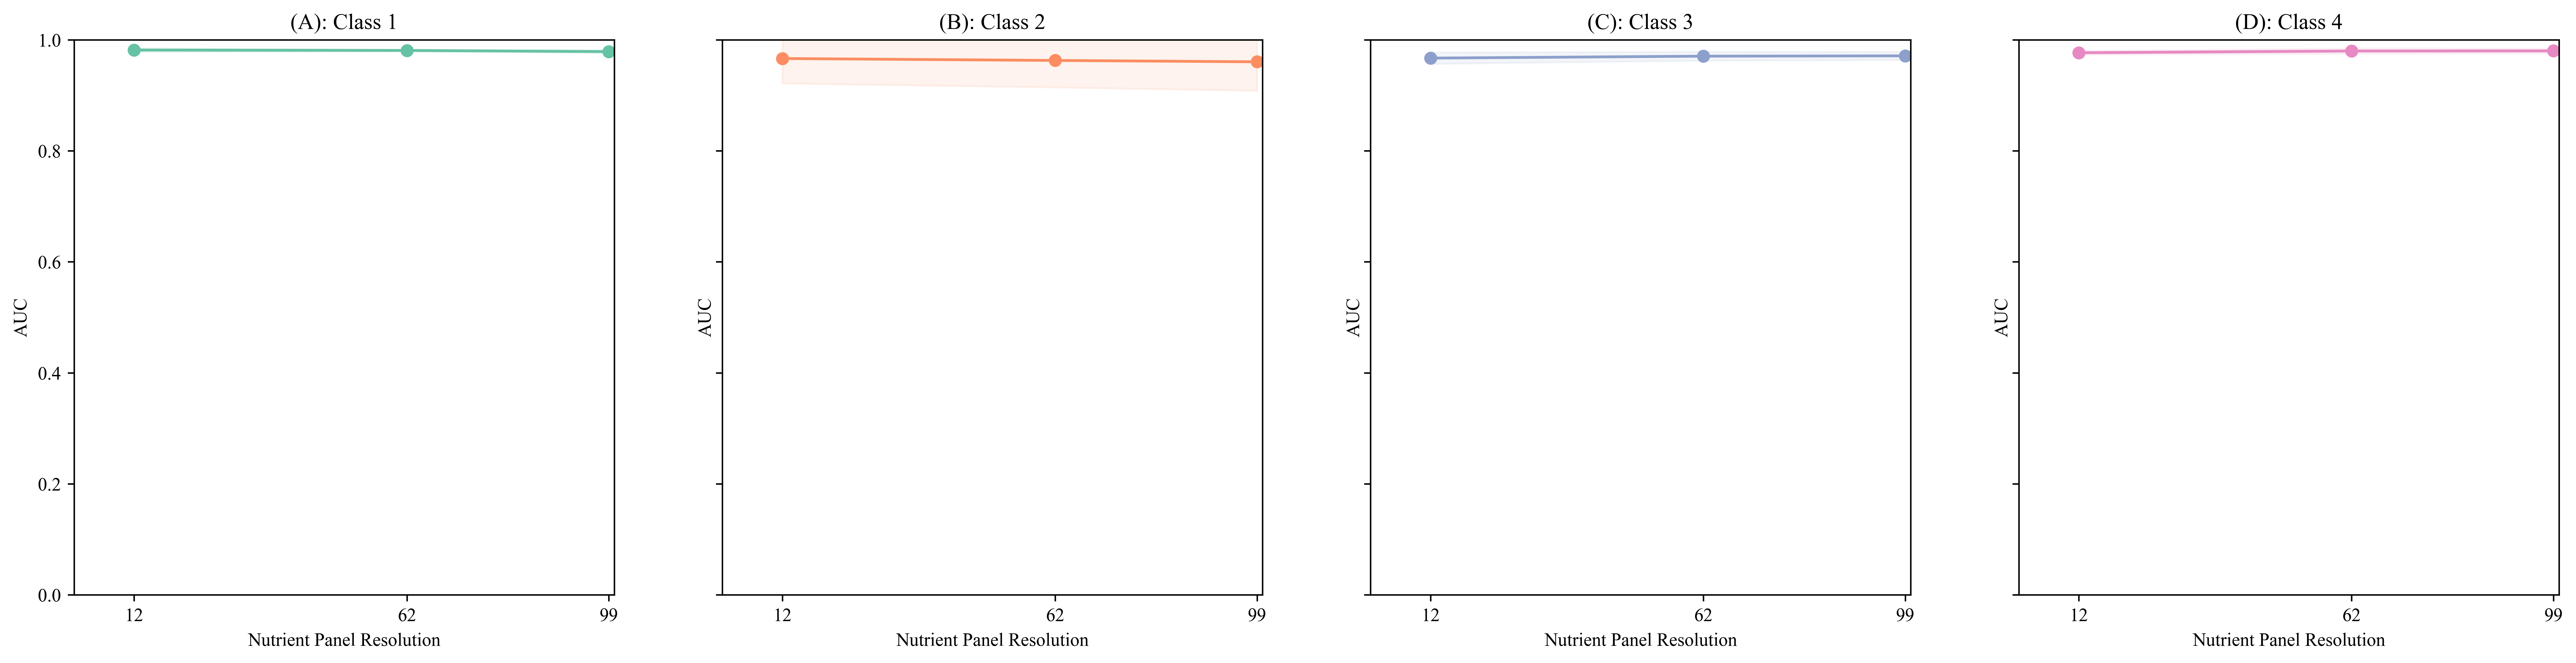

In [92]:
# subplot AUC
numclass=4
nuttablenum=[12,62,99]
panelletter=['(A): ', '(B): ','(C): ', '(D): ' ]
fig, axes = plt.subplots(1, numclass, figsize=(24,5.5), dpi=600, sharex=True, sharey=True)
for cc,ax in enumerate(axes.flatten()):
    performancesAUCL=[performancesAUCNF[:,cc],performancesAUCSR[:,cc],performancesAUCWNP[:,cc]]
    LineAUC(performancesAUCL, nuttablenum, cc, labeld,colorclass[cc],ax)
    ax.set(xlim=[1, 100], ylim=[0, 1], title=panelletter[cc]+"Class "+ str(cc+1))   
    ax.set_xlabel('Nutrient Panel Resolution')
    ax.set_ylabel('AUC')
    plt.xticks(nuttablenum)

plt.savefig("AUCCurves.png", dpi=600)

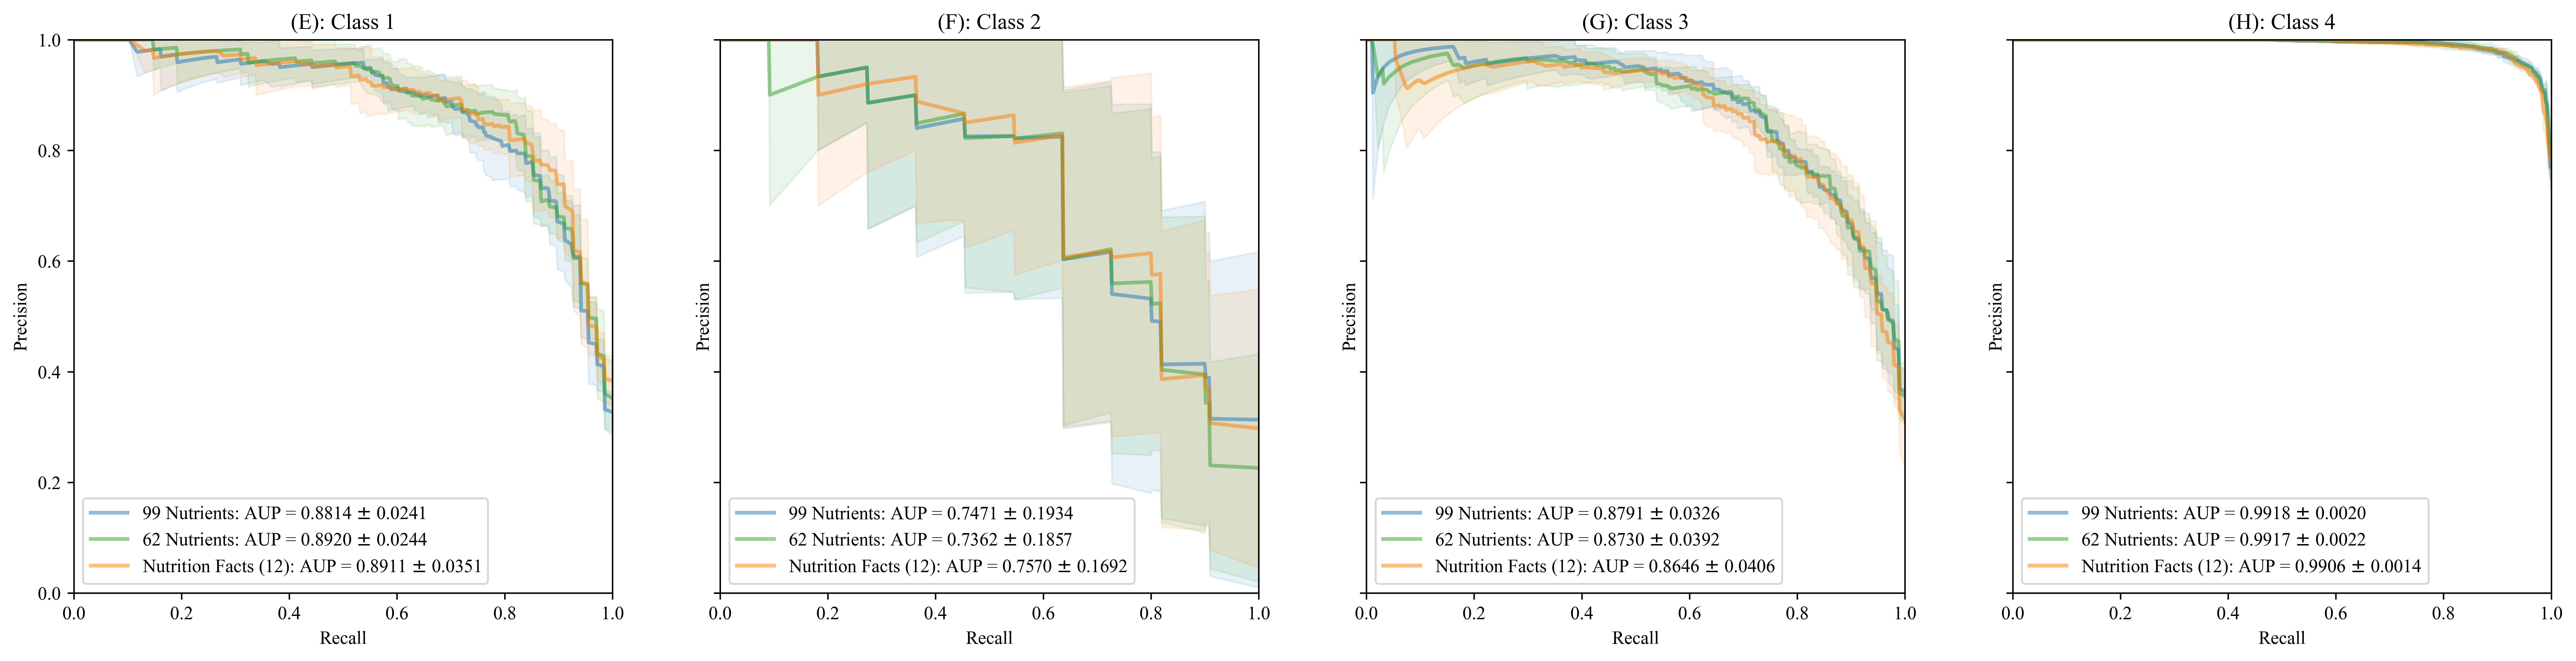

In [107]:
def PrecisionRecallMultiPlotCallable(mean_recallL, mean_precisionL, std_precisionL, precision_upperL, precision_lowerL, performancesAUPL, labelc, labeld, colord,ax):
    mean_aup=[p.mean(axis=0) for p in  performancesAUPL]
    std_aup=[p.std(axis=0) for p in  performancesAUPL]
    
    for d in range(len(labeld)):
        ax.plot(mean_recallL[d], mean_precisionL[d], color=colord[d],label=labeld[d]+ r': AUP = %0.4f $\pm$ %0.4f' % (mean_aup[d], std_aup[d]), lw=2, alpha=.5)
        ax.fill_between(mean_recallL[d], precision_lowerL[d], precision_upperL[d], color=colord[d], alpha=.1)

    ax.legend(loc="lower left")

def LineAUP(performancesAUPL, nuttablenum, labelc,labeld,singlecolor,ax):
    nuttablenum=np.array(nuttablenum)
    mean_aup=np.array([p.mean(axis=0) for p in  performancesAUPL])
    std_aup=np.array([p.std(axis=0) for p in  performancesAUPL])
    ax.plot(nuttablenum, mean_aup, 'o-', color=singlecolor)
    ax.fill_between(nuttablenum, mean_aup - std_aup, mean_aup + std_aup, color=singlecolor, alpha=0.2)    


# subplots Precision Recall curve
numclass=4
panelletter=['(E): ', '(F): ','(G): ', '(H): ' ]
fig, axes = plt.subplots(1, numclass, figsize=(24,5.5), dpi=600, sharex=True, sharey=True)
for cc,ax in enumerate(axes.flatten()):
    mean_recallL=[mean_recallWNP, mean_recallSR, mean_recallNF]
    mean_precisionL=[mean_precisionWNP[cc], mean_precisionSR[cc], mean_precisionNF[cc]]
    std_precisionL=[std_precisionWNP[cc], std_precisionSR[cc], std_precisionNF[cc]]
    precision_upperL=[precision_upperWNP[cc], precision_upperSR[cc], precision_upperNF[cc]]
    precision_lowerL=[precision_lowerWNP[cc], precision_lowerSR[cc], precision_lowerNF[cc]]
    performancesAUPL=[performancesAUPWNP[:,cc], performancesAUPSR[:,cc], performancesAUPNF[:,cc]]
    PrecisionRecallMultiPlotCallable(mean_recallL, mean_precisionL, std_precisionL, precision_upperL, precision_lowerL, performancesAUPL, cc, labeld, colord,ax)
    ax.set(xlim=[0, 1], ylim=[0, 1], title=panelletter[cc]+"Class "+ str(cc+1))   
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    
    
plt.savefig("PrecisionRecallCurves.png", dpi=600)

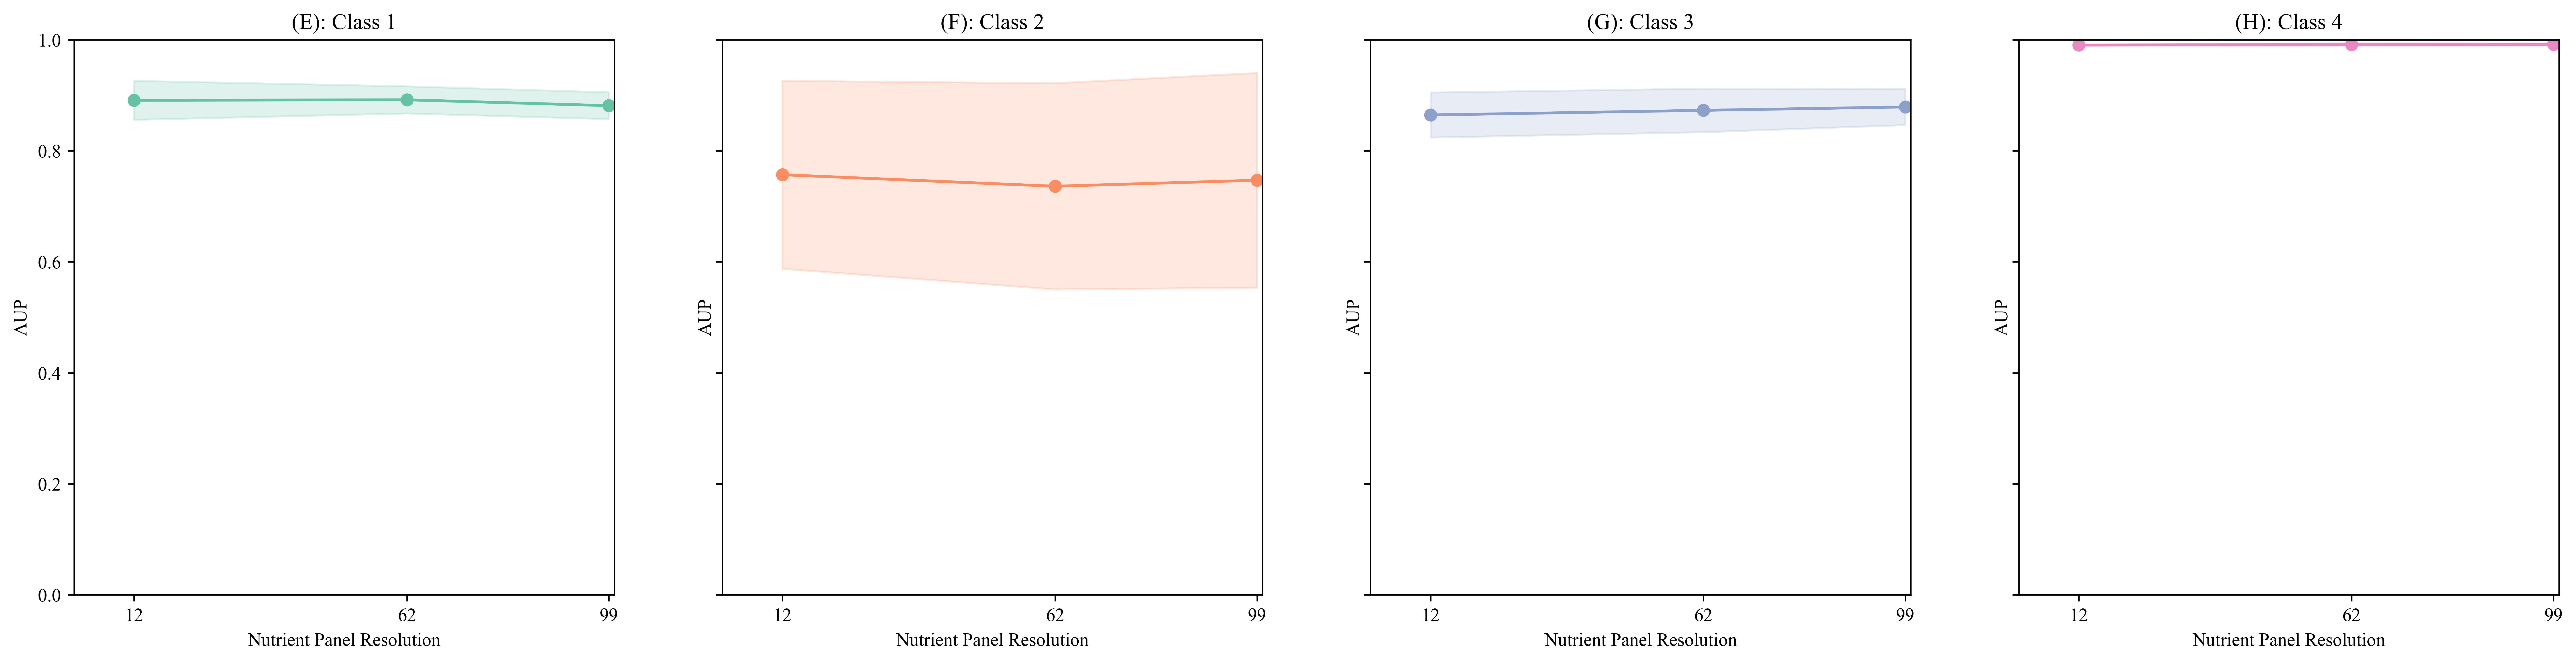

In [96]:
# subplot AUP
numclass=4
nuttablenum=[12,62,99]
panelletter=['(E): ', '(F): ','(G): ', '(H): ' ]
fig, axes = plt.subplots(1, numclass, figsize=(24,5.5), dpi=600, sharex=True, sharey=True)
for cc,ax in enumerate(axes.flatten()):
    performancesAUPL=[performancesAUPNF[:,cc],performancesAUPSR[:,cc],performancesAUPWNP[:,cc]]
    LineAUP(performancesAUPL, nuttablenum, cc, labeld,colorclass[cc],ax)
    ax.set(xlim=[1, 100], ylim=[0, 1], title=panelletter[cc]+"Class "+ str(cc+1))   
    ax.set_xlabel('Nutrient Panel Resolution')
    ax.set_ylabel('AUP')
    plt.xticks(nuttablenum)
    
plt.savefig("AUPCurves.png", dpi=600)

# To Export

In [127]:
dataAUC=np.array([performancesAUCNF.mean(axis=0),performancesAUCNF.std(axis=0),
 performancesAUCSR.mean(axis=0), performancesAUCSR.std(axis=0), 
 performancesAUCWNP.mean(axis=0), performancesAUCWNP.std(axis=0),
 np.array([performancesAUCNF.mean(axis=0),performancesAUCSR.mean(axis=0), performancesAUCWNP.mean(axis=0)]).mean(axis=0),
 np.array([performancesAUCNF.mean(axis=0),performancesAUCSR.mean(axis=0), performancesAUCWNP.mean(axis=0)]).std(axis=0)])

In [128]:
df = pd.DataFrame(data=dataAUC, index=["Average AUC Nutrition Facts", "Std AUC Nutrition Facts", "Average AUC 62 Nutrients", "Std AUC 62 Nutrients","Average AUC 99 Nutrients", "Std AUC 99 Nutrients", "Average AUC", "Std AUC"],
                  columns=["NOVA 1", "NOVA 2", "NOVA 3", "NOVA 4"])
df.to_csv('summaryAUC.csv')
df


,NOVA 1,NOVA 2,NOVA 3,NOVA 4
Average AUC Nutrition Facts,0.981662,0.966348,0.967094,0.976772
Std AUC Nutrition Facts,0.003621,0.044898,0.010411,0.003432
Average AUC 62 Nutrients,0.980837,0.962878,0.970605,0.979866
Std AUC 62 Nutrients,0.001730,0.048586,0.008060,0.004876
Average AUC 99 Nutrients,0.978806,0.960406,0.971156,0.980085
Std AUC 99 Nutrients,0.002772,0.052151,0.007394,0.004237
Average AUC,0.980435,0.963211,0.969618,0.978908
Std AUC,0.001200,0.002437,0.001799,0.001513


In [129]:
dataAUP=np.array([performancesAUPNF.mean(axis=0),performancesAUPNF.std(axis=0),
 performancesAUPSR.mean(axis=0), performancesAUPSR.std(axis=0), 
 performancesAUPWNP.mean(axis=0), performancesAUPWNP.std(axis=0),
 np.array([performancesAUPNF.mean(axis=0),performancesAUPSR.mean(axis=0), performancesAUPWNP.mean(axis=0)]).mean(axis=0),
 np.array([performancesAUPNF.mean(axis=0),performancesAUPSR.mean(axis=0), performancesAUPWNP.mean(axis=0)]).std(axis=0)])                

In [131]:
df = pd.DataFrame(data=dataAUP, index=["Average AUP Nutrition Facts", "Std AUP Nutrition Facts", "Average AUP 62 Nutrients", "Std AUP 62 Nutrients","Average AUP 99 Nutrients", "Std AUP 99 Nutrients", "Average AUP", "Std AUP"],
                  columns=["NOVA 1", "NOVA 2", "NOVA 3", "NOVA 4"])
df.to_csv('summaryAUP.csv')
df

,NOVA 1,NOVA 2,NOVA 3,NOVA 4
Average AUP Nutrition Facts,0.891112,0.756997,0.864605,0.990558
Std AUP Nutrition Facts,0.035105,0.169225,0.040566,0.001414
Average AUP 62 Nutrients,0.891971,0.736245,0.873025,0.991702
Std AUP 62 Nutrients,0.024412,0.185744,0.039220,0.002178
Average AUP 99 Nutrients,0.881419,0.747070,0.879123,0.991783
Std AUP 99 Nutrients,0.024092,0.193387,0.032601,0.001954
Average AUP,0.888168,0.746770,0.872251,0.991348
Std AUP,0.004785,0.008475,0.005952,0.000560
